In [25]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error,r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [218]:
data= pd.read_csv('Pizzasales.csv')

In [219]:
data.drop(columns=['Unnamed: 0'], inplace=True)

ENCODING TECHNIQUE

In [217]:
data['order_date'] = pd.to_datetime(data['order_date'], errors='coerce')

In [220]:
columns_to_drop = ['order_id', 'order_time', 'unit_price','quarter']
data = data.drop(columns=columns_to_drop)

In [221]:
label_encoder = LabelEncoder()

columns_to_encode = ['pizza_name_id', 'pizza_name', 'pizza_category', 'pizza_ingredients','pizza_size']

for column in columns_to_encode:
    data[column] = label_encoder.fit_transform(data[column])

In [222]:
data

,pizza_id,pizza_name_id,quantity,order_date,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,day_of_week,month,year,is_weekend,day_of_year,is_holiday
0,1,27,1,2015-01-01,13.25,1,1,23,12,3,1,2015,0,1,0
1,2,18,1,2015-01-01,16.00,1,1,20,7,3,1,2015,0,1,0
2,3,20,1,2015-01-01,18.50,0,3,17,8,3,1,2015,0,1,0
3,4,32,1,2015-01-01,20.75,0,2,4,14,3,1,2015,0,1,0
4,5,42,1,2015-01-01,16.00,1,3,31,17,3,1,2015,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48615,48616,12,1,2015-12-31,16.75,1,0,9,5,3,12,2015,0,365,0
48616,48617,21,1,2015-12-31,17.95,0,3,22,9,3,12,2015,0,365,0
48617,48618,46,1,2015-12-31,12.00,2,1,30,18,3,12,2015,0,365,0
48618,48619,41,1,2015-12-31,20.25,0,3,31,17,3,12,2015,0,365,0


In [116]:
data.dtypes

pizza_id                      int64
pizza_name_id                 int64
quantity                      int64
order_date           datetime64[ns]
total_price                 float64
pizza_size                    int64
pizza_category                int64
pizza_ingredients             int64
pizza_name                    int64
day_of_week                   int64
month                         int64
year                          int64
is_weekend                    int64
day_of_year                   int64
is_holiday                    int64
dtype: object

In [117]:
data.columns

Index(['pizza_id', 'pizza_name_id', 'quantity', 'order_date', 'total_price',
       'pizza_size', 'pizza_category', 'pizza_ingredients', 'pizza_name',
       'day_of_week', 'month', 'year', 'is_weekend', 'day_of_year',
       'is_holiday'],
      dtype='object')

In [118]:
data.isnull().sum()

pizza_id             0
pizza_name_id        0
quantity             0
order_date           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
day_of_week          0
month                0
year                 0
is_weekend           0
day_of_year          0
is_holiday           0
dtype: int64

MODEL TRAINING

ARIMA MODEL

In [119]:
data['order_date'] = pd.to_datetime(data['order_date'])

In [120]:
data.set_index('order_date', inplace=True)

In [126]:
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

In [127]:
y_train = train_data['quantity']
y_test = test_data['quantity']

In [128]:
lag_order = 5 
ar_model = ARIMA(y_train, order=(lag_order, 1, 0)) 
ar_results = ar_model.fit()

In [129]:
y_pred = ar_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

In [130]:
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Mean Absolute Percentage Error: {mape:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')

Mean Absolute Percentage Error: 0.0097
Root Mean Squared Error: 0.1441


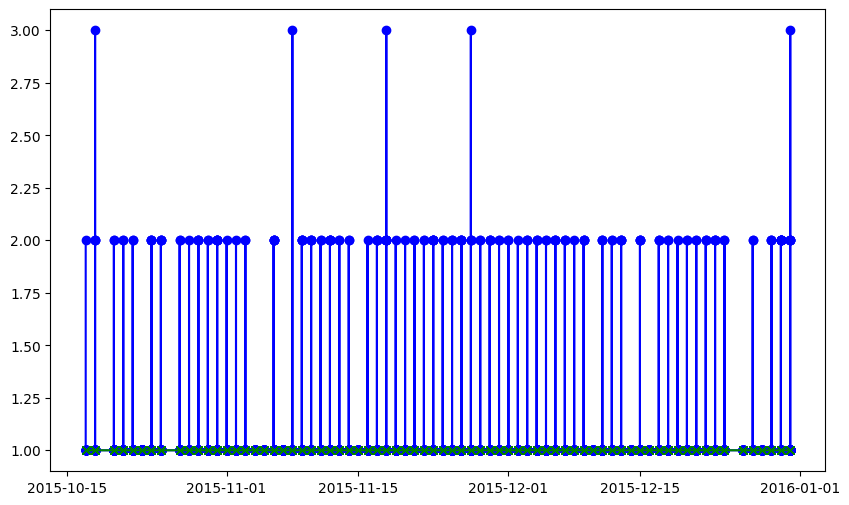

In [132]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted (Test)', color='green', marker='x')

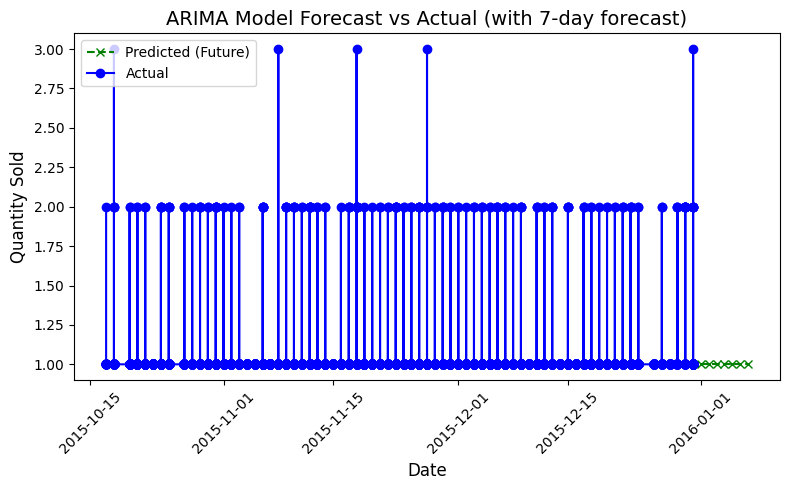

In [139]:
y_pred_future = y_pred[-7:]
future_dates = pd.date_range(start=y_test.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')

plt.figure(figsize=(8, 5))
plt.plot(future_dates, y_pred_future, label='Predicted (Future)', color='green', marker='x', linestyle='--')
plt.plot(y_test.index, y_test.values, label='Actual', color='blue', linestyle='-', marker='o')
plt.title('ARIMA Model Forecast vs Actual (with 7-day forecast)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

In [141]:
comparison_df_arima = pd.DataFrame({
    'Actual': list(y_test) + [None] * 7,  
    'Predicted': list(y_pred) + list(y_pred_future)
}, index=list(y_test.index) + list(future_dates))

print(comparison_df_arima.head())

            Actual  Predicted
2015-10-17     2.0        1.0
2015-10-17     1.0        1.0
2015-10-17     1.0        1.0
2015-10-17     1.0        1.0
2015-10-17     1.0        1.0


SARIMA model

In [144]:
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

In [145]:
y_train = train_data['quantity']
y_test = test_data['quantity']

In [146]:
lag_order = 5  
seasonal_order = (1, 1, 1, 12)

In [147]:
sarima_model = SARIMAX(y_train, order=(lag_order, 1, 0), seasonal_order=seasonal_order)
sarima_results = sarima_model.fit()

In [148]:
y_pred = sarima_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

In [149]:
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Mean Absolute Percentage Error: {mape:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')

Mean Absolute Percentage Error: 0.0118
Root Mean Squared Error: 0.1443


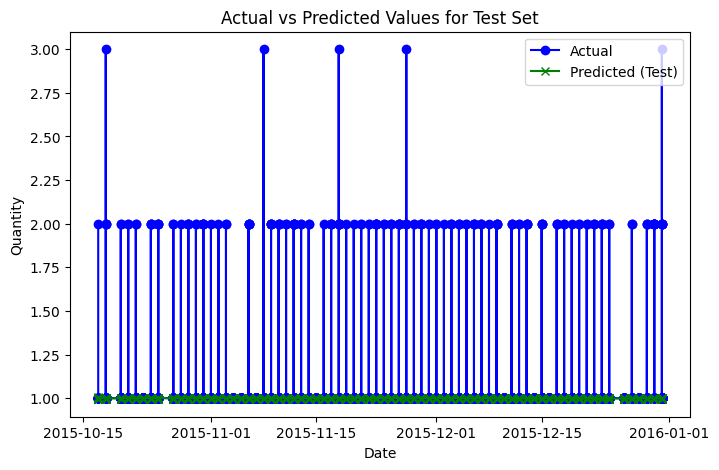

In [151]:
plt.figure(figsize=(8, 5))
plt.plot(y_test.index, y_test, label='Actual', color='blue', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted (Test)', color='green', marker='x')
plt.title('Actual vs Predicted Values for Test Set')  
plt.xlabel('Date') 
plt.ylabel('Quantity')
plt.legend()
plt.show()

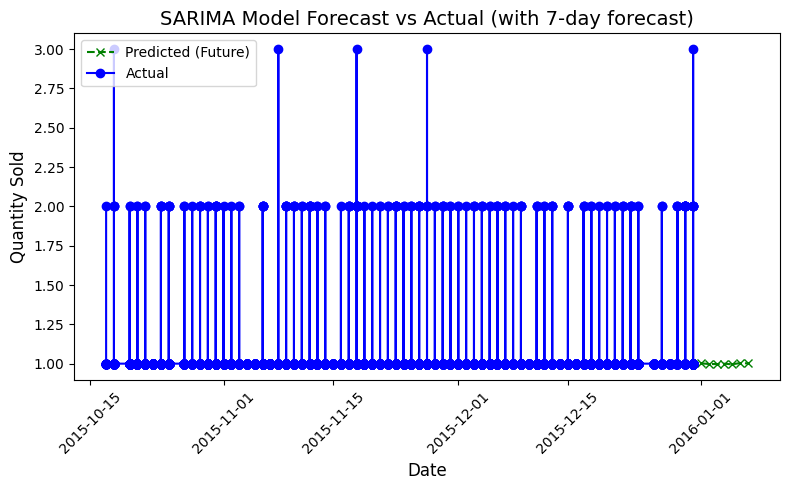

In [153]:
y_pred_future = sarima_results.predict(start=len(train_data), end=len(train_data) + 7 - 1, dynamic=False)
future_dates = pd.date_range(start=y_test.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')

plt.figure(figsize=(8, 5))
plt.plot(future_dates, y_pred_future, label='Predicted (Future)', color='green', marker='x', linestyle='--')
plt.plot(y_test.index, y_test.values, label='Actual', color='blue', linestyle='-', marker='o')
plt.title('SARIMA Model Forecast vs Actual (with 7-day forecast)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [154]:
comparison_df_sarima = pd.DataFrame({
    'Actual': list(y_test) + [None] * 7,  
    'Predicted': list(y_pred) + list(y_pred_future)
}, index=list(y_test.index) + list(future_dates))

print(comparison_df_sarima.head()) 

            Actual  Predicted
2015-10-17     2.0   1.002195
2015-10-17     1.0   0.997832
2015-10-17     1.0   0.997323
2015-10-17     1.0   0.999539
2015-10-17     1.0   0.995781


PROPHET model

In [223]:
data_p = data[['order_date', 'quantity']].rename(columns={'order_date': 'ds', 'quantity': 'y'})
data_p.head()

,ds,y
0,2015-01-01,1
1,2015-01-01,1
2,2015-01-01,1
3,2015-01-01,1
4,2015-01-01,1


In [224]:
model_p = Prophet()
model_p.fit(data_p)

17:50:28 - cmdstanpy - INFO - Chain [1] start processing
17:50:31 - cmdstanpy - INFO - Chain [1] done processing


In [225]:
future = model_p.make_future_dataframe(periods=7) 
forecast = model_p.predict(future)

In [226]:
forecast_next_7_days=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast_next_7_days

,ds,yhat,yhat_lower,yhat_upper
360,2016-01-03,1.021104,0.841565,1.212678
361,2016-01-04,1.019360,0.837630,1.197887
362,2016-01-05,1.022233,0.840757,1.196592
363,2016-01-06,1.023114,0.848076,1.221045
364,2016-01-07,1.022312,0.831162,1.211035


In [227]:
train = data_p[:-7]  
test = data_p[-7:]

In [228]:
forecast_test = model_p.predict(test)

In [229]:
rmse = np.sqrt(mean_squared_error(test['y'], forecast_test['yhat']))
mape = mean_absolute_percentage_error(test['y'], forecast_test['yhat'])
print(f'Mean Absolute Percentage Error: {mape:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')

Mean Absolute Percentage Error: 0.0222
Root Mean Squared Error: 0.0222


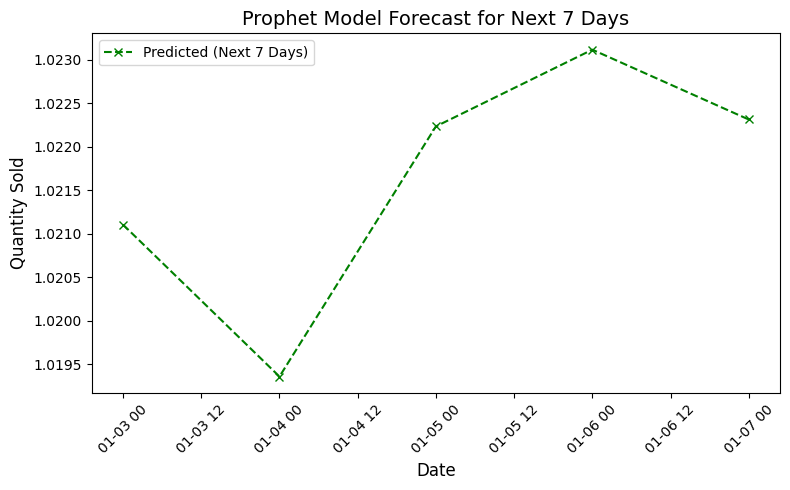

In [234]:
plt.figure(figsize=(8, 5))
plt.plot(forecast_next_7_days['ds'].dt.to_pydatetime(), forecast_next_7_days['yhat'], label='Predicted (Next 7 Days)',
          color='green', marker='x', linestyle='--', markersize=6)
plt.title('Prophet Model Forecast for Next 7 Days', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [235]:
comparison_df_prophet = pd.DataFrame({
    'Actual': test['y'].values,
    'Predicted': forecast_test['yhat'].values
}, index=test['ds'])

print(comparison_df_prophet.head())

            Actual  Predicted
ds                           
2015-12-31       1    1.02223
2015-12-31       1    1.02223
2015-12-31       1    1.02223
2015-12-31       1    1.02223
2015-12-31       1    1.02223


ARIMA is the better model, as it achieves the lowest error metrics and performs well in terms of the other metrics compared to the others.